In [1]:
#load library
library(broom)
library(tidyverse)
library(dplyr)
library(lubridate)
library(grid)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




**Data Coloumn Interpretation**


No: row number

year: year of data in this row

month: month of data in this row

day: day of data in this row

hour: hour of data in this row

pm2.5: $PM2.5$ concentration $(ug/m^3)$ 

DEWP: Dew Point $(°C)$
dew point temperature is not dependent on temperature 
(https://www.vaisala.com/en/expert-article/dew-point-temperature-what-does-it-mean-and-how-can-it-be-calculated)

TEMP: Temperature $(°C)$

PRES: Pressure $(hPa)$

cbwd: Combined wind direction

Iws: Cumulated wind speed $(m/s)$

Is: Cumulated hours of snow

Ir: Cumulated hours of rain

In [2]:
# loading data
pm2.5 <- read.csv("~/project.csv", header=TRUE)
pm2.5 <- as_tibble(pm2.5)
head(pm2.5)

No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>
1,2010,1,1,0,NA,-21,-11,1021,NW,1.79,0,0
2,2010,1,1,1,NA,-21,-12,1020,NW,4.92,0,0
3,2010,1,1,2,NA,-21,-11,1019,NW,6.71,0,0
4,2010,1,1,3,NA,-21,-14,1019,NW,9.84,0,0
5,2010,1,1,4,NA,-20,-12,1018,NW,12.97,0,0
6,2010,1,1,5,NA,-19,-10,1017,NW,16.10,0,0


**Removing 24 hours data for one day if one hour missing**

From the original data, we can see that the data set is counted by hour, so there should be $24$ data per day, but some data are not measured at certain points in time because of observation, so in order to facilitate the statistical value of $pm2.5$ by day, so if there is a missing value in a day, then we delete the $pm2.5$ data of all moments of that day.

In [3]:
#remove the all the moments of a day with at least one hour missing data
#remove the line with missing data
pm2.5_n<- na.omit(pm2.5)
#number of data witout na
nrow(pm2.5_n)

pm2.5_tidy<- pm2.5_n%>%add_count(year,month,day)%>%
  filter(n==24)
# number of remined data
nrow(pm2.5_tidy)

# view the dataframe to make sure it is processed properly
head(pm2.5_tidy)

[1] 41757

[1] 37704

No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,n
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>
25,2010,1,2,0,129,-16,-4,1020,SE,1.79,0,0,24
26,2010,1,2,1,148,-15,-4,1020,SE,2.68,0,0,24
27,2010,1,2,2,159,-11,-5,1021,SE,3.57,0,0,24
28,2010,1,2,3,181,-7,-5,1022,SE,5.36,1,0,24
29,2010,1,2,4,138,-7,-5,1022,SE,6.25,2,0,24
30,2010,1,2,5,109,-7,-6,1022,SE,7.14,3,0,24


In [4]:
#Summarize the data, counting how many occurences of each year
pm2.5_tidy%>%
  group_by(year)%>%
  summarize(count=n())

year,count
<int>,<int>
2010,7680
2011,6912
2012,7200
2013,7920
2014,7992


To further explore the **seasonal characteristics** of pm2.5 index, we need to divide the original data into seasons, where March, April and May are classified as **spring**, June, July and August are classified as **summer**, September, October and November are classified as **autumn**, and December, January and February are classified as **winter**. 

season,n
<chr>,<int>
Fall,9552
Spring,9312
Summer,9072
Winter,9768


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


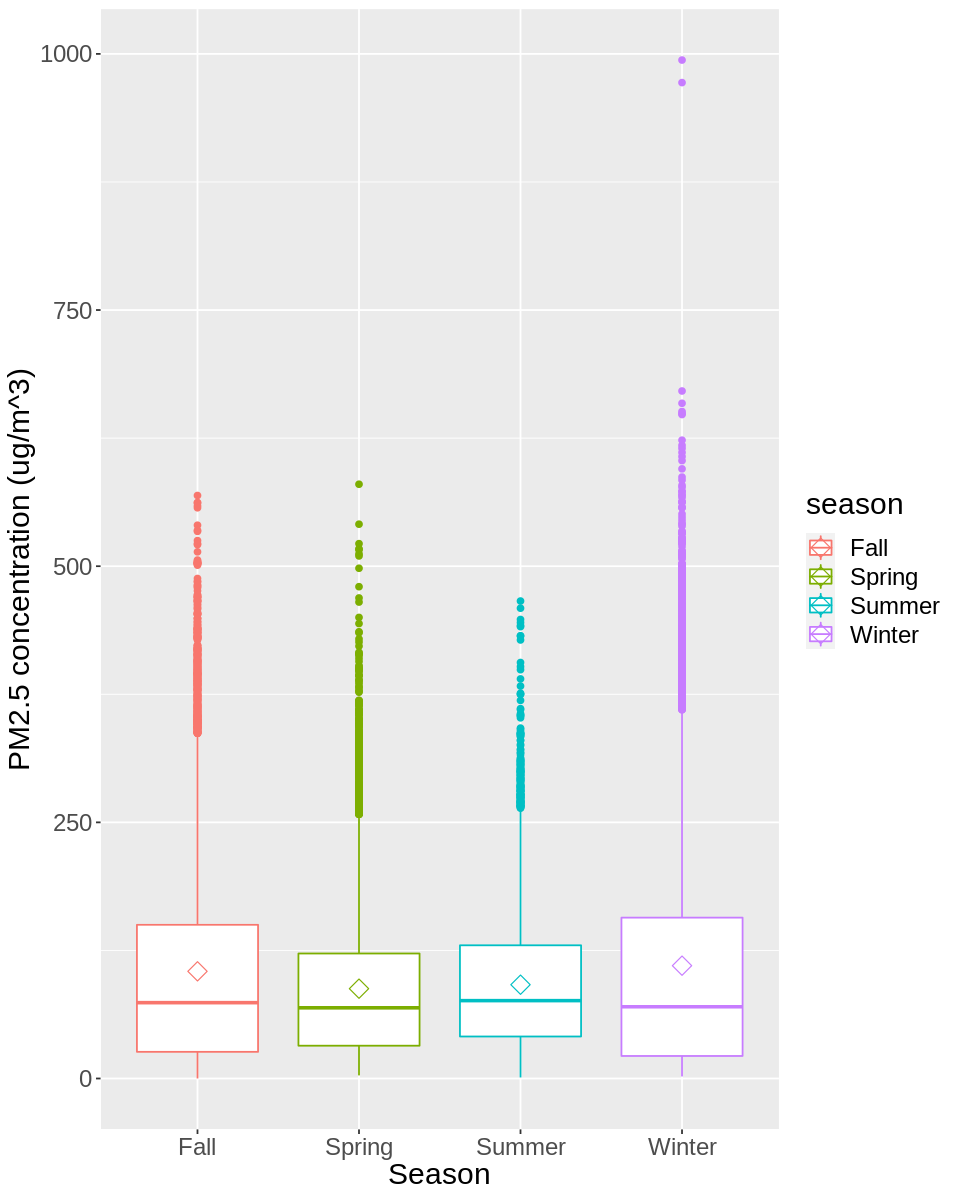

In [5]:
#classify with season
pm2.5_s <- pm2.5_tidy %>%
  mutate(
    season = case_when(
      month %in% 9:11 ~ "Fall",
      month %in%  3:5  ~ "Spring",
      month %in%  6:8  ~ "Summer",
      TRUE ~ "Winter"))
#season check
season_check<-pm2.5_s%>% group_by(season)%>% summarize(n=n())
season_check
#use box plot to explore the seasonal characteristics of pm2.5 index 
options(repr.plot.width = 8, repr.plot.height = 10)
season_p<-ggplot(pm2.5_s, aes(x=season, y=pm2.5, color=season)) +
  geom_boxplot() +
  xlab("Season") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))+
  # Box plot with mean points
  stat_summary(fun.y=mean, geom="point", shape=23, size=4)

season_p

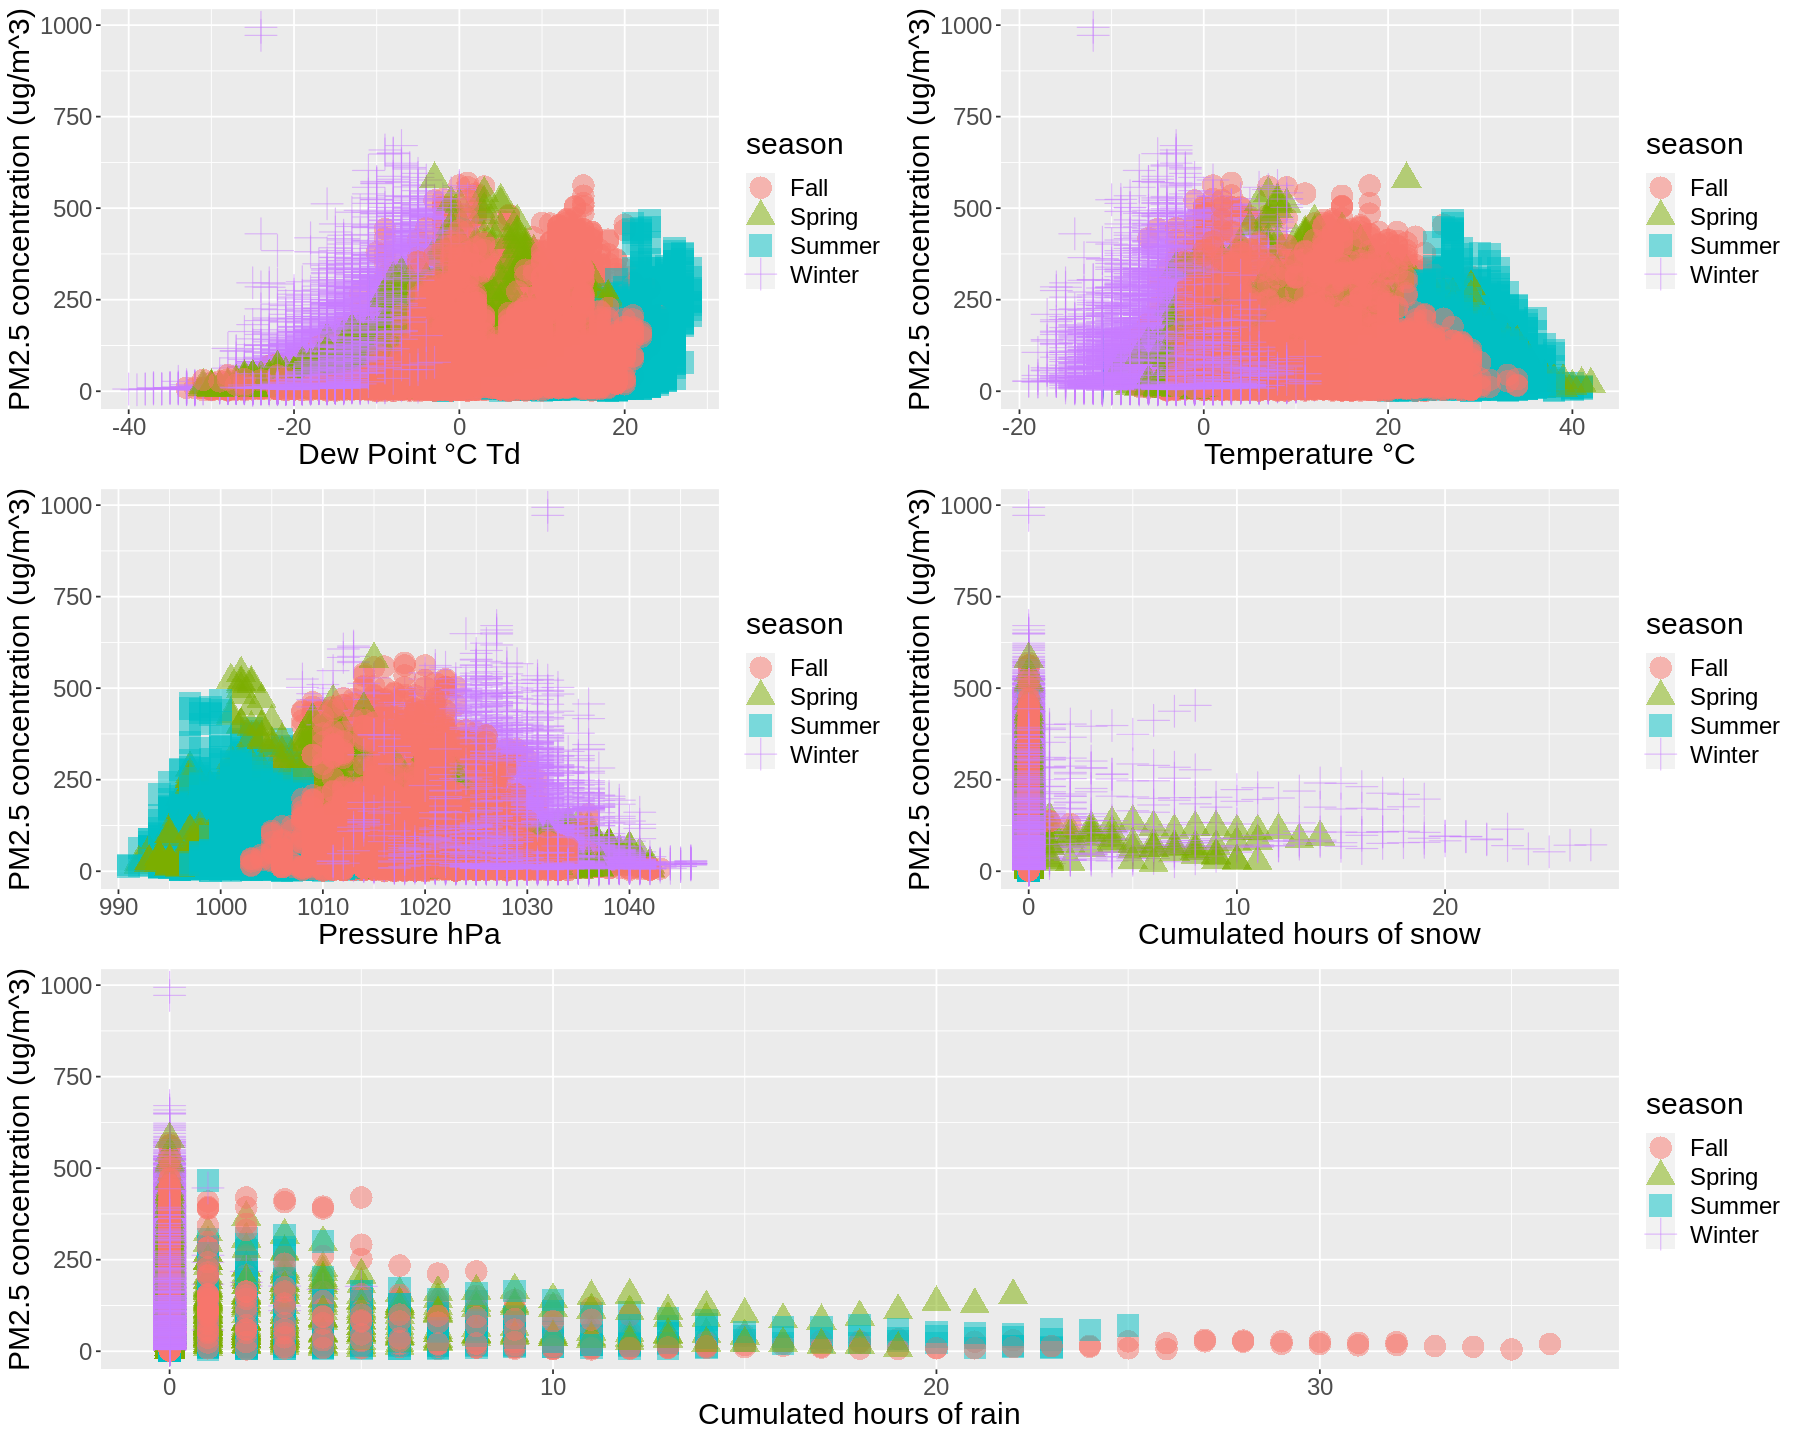

In [6]:
options(repr.plot.width = 15, repr.plot.height = 12)
dewp <- ggplot(pm2.5_s, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    aes(color = season, shape = season),
    size = 6,
    alpha = 0.5
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

temp <- ggplot(pm2.5_s, aes(x =TEMP , y = pm2.5)) +
  geom_point(
    aes(color = season, shape = season),
    size = 6,
    alpha = 0.5
  )+
  xlab("Temperature °C") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

pres <- ggplot(pm2.5_s, aes(x =PRES , y = pm2.5)) +
  geom_point(
    aes(color = season, shape = season),
    size = 6,
    alpha = 0.5
  )+
  xlab("Pressure hPa") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))


snow <- ggplot(pm2.5_s, aes(x =Is , y = pm2.5)) +
  geom_point(
    aes(color = season, shape = season),
    size = 6,
    alpha = 0.5
  )+
  xlab("Cumulated hours of snow") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

rain <- ggplot(pm2.5_s, aes(x =Ir , y = pm2.5)) +
  geom_point(
    aes(color = season, shape = season),
    size = 6,
    alpha = 0.5
  )+
  xlab("Cumulated hours of rain") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

grid.newpage()
pushViewport(viewport(layout = grid.layout(3,2))) 
vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)
print(dewp, vp = vplayout(1,1))   
print(temp, vp = vplayout(1,2))
print(pres, vp = vplayout(2,1))
print(snow, vp = vplayout(2,2))
print(rain, vp = vplayout(3,1:2))

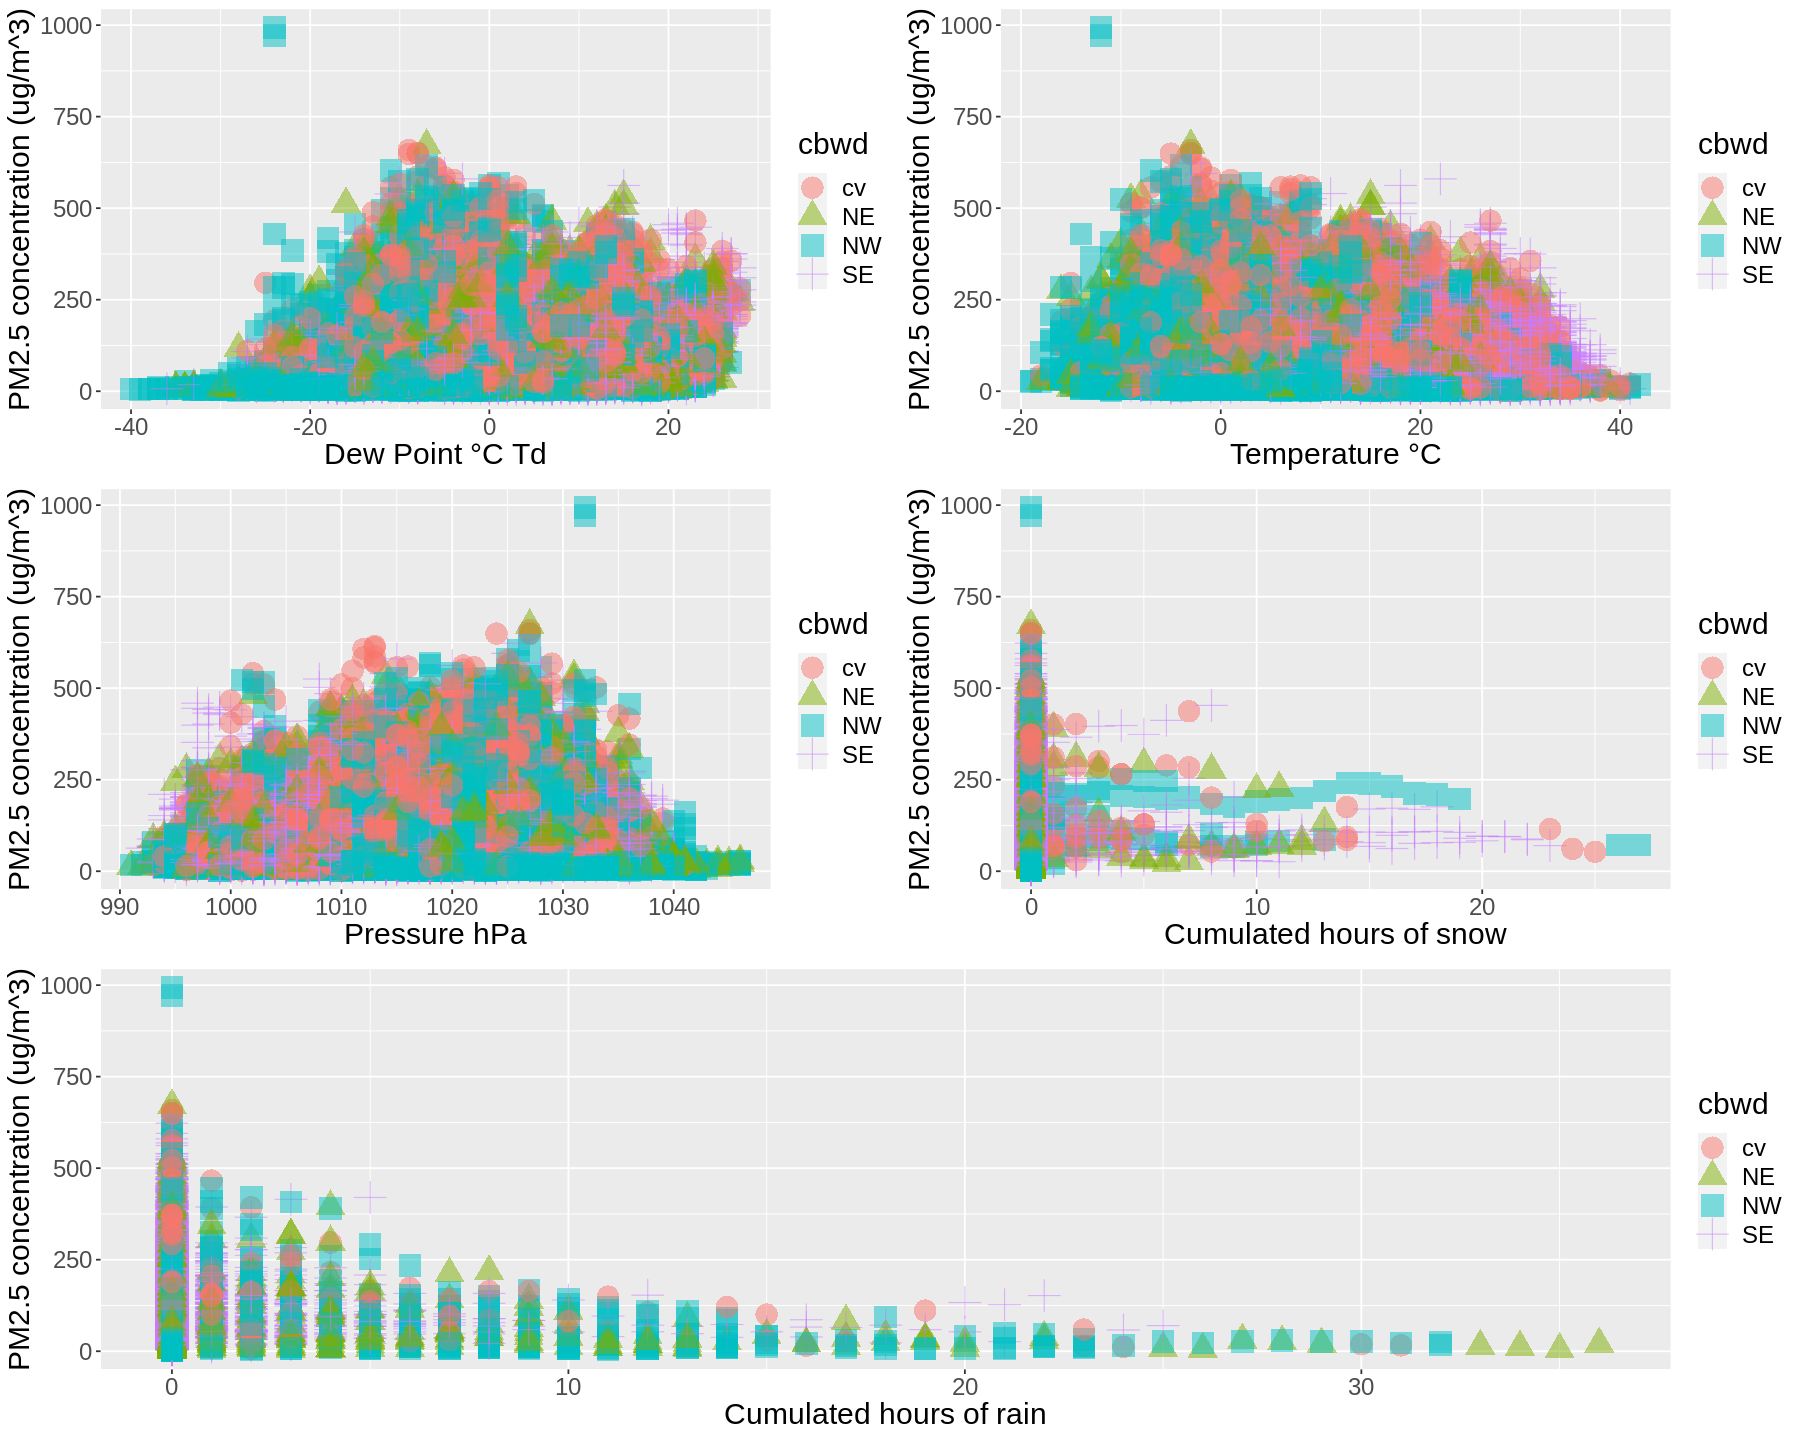

In [18]:
options(repr.plot.width = 15, repr.plot.height = 12)
# wind direction 
dewp <- ggplot(pm2.5_s, aes(x = DEWP, y = pm2.5)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Dew Point °C Td") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

temp <- ggplot(pm2.5_s, aes(x =TEMP , y = pm2.5)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Temperature °C") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

pres <- ggplot(pm2.5_s, aes(x =PRES , y = pm2.5)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Pressure hPa") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))


snow <- ggplot(pm2.5_s, aes(x =Is , y = pm2.5)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Cumulated hours of snow") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

rain <- ggplot(pm2.5_s, aes(x =Ir , y = pm2.5)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Cumulated hours of rain") +
  ylab("PM2.5 concentration (ug/m^3)") +
  theme(text = element_text(size = 18))

grid.newpage()
pushViewport(viewport(layout = grid.layout(3,2))) 
vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)
print(dewp, vp = vplayout(1,1))   
print(temp, vp = vplayout(1,2))
print(pres, vp = vplayout(2,1))
print(snow, vp = vplayout(2,2))
print(rain, vp = vplayout(3,1:2))

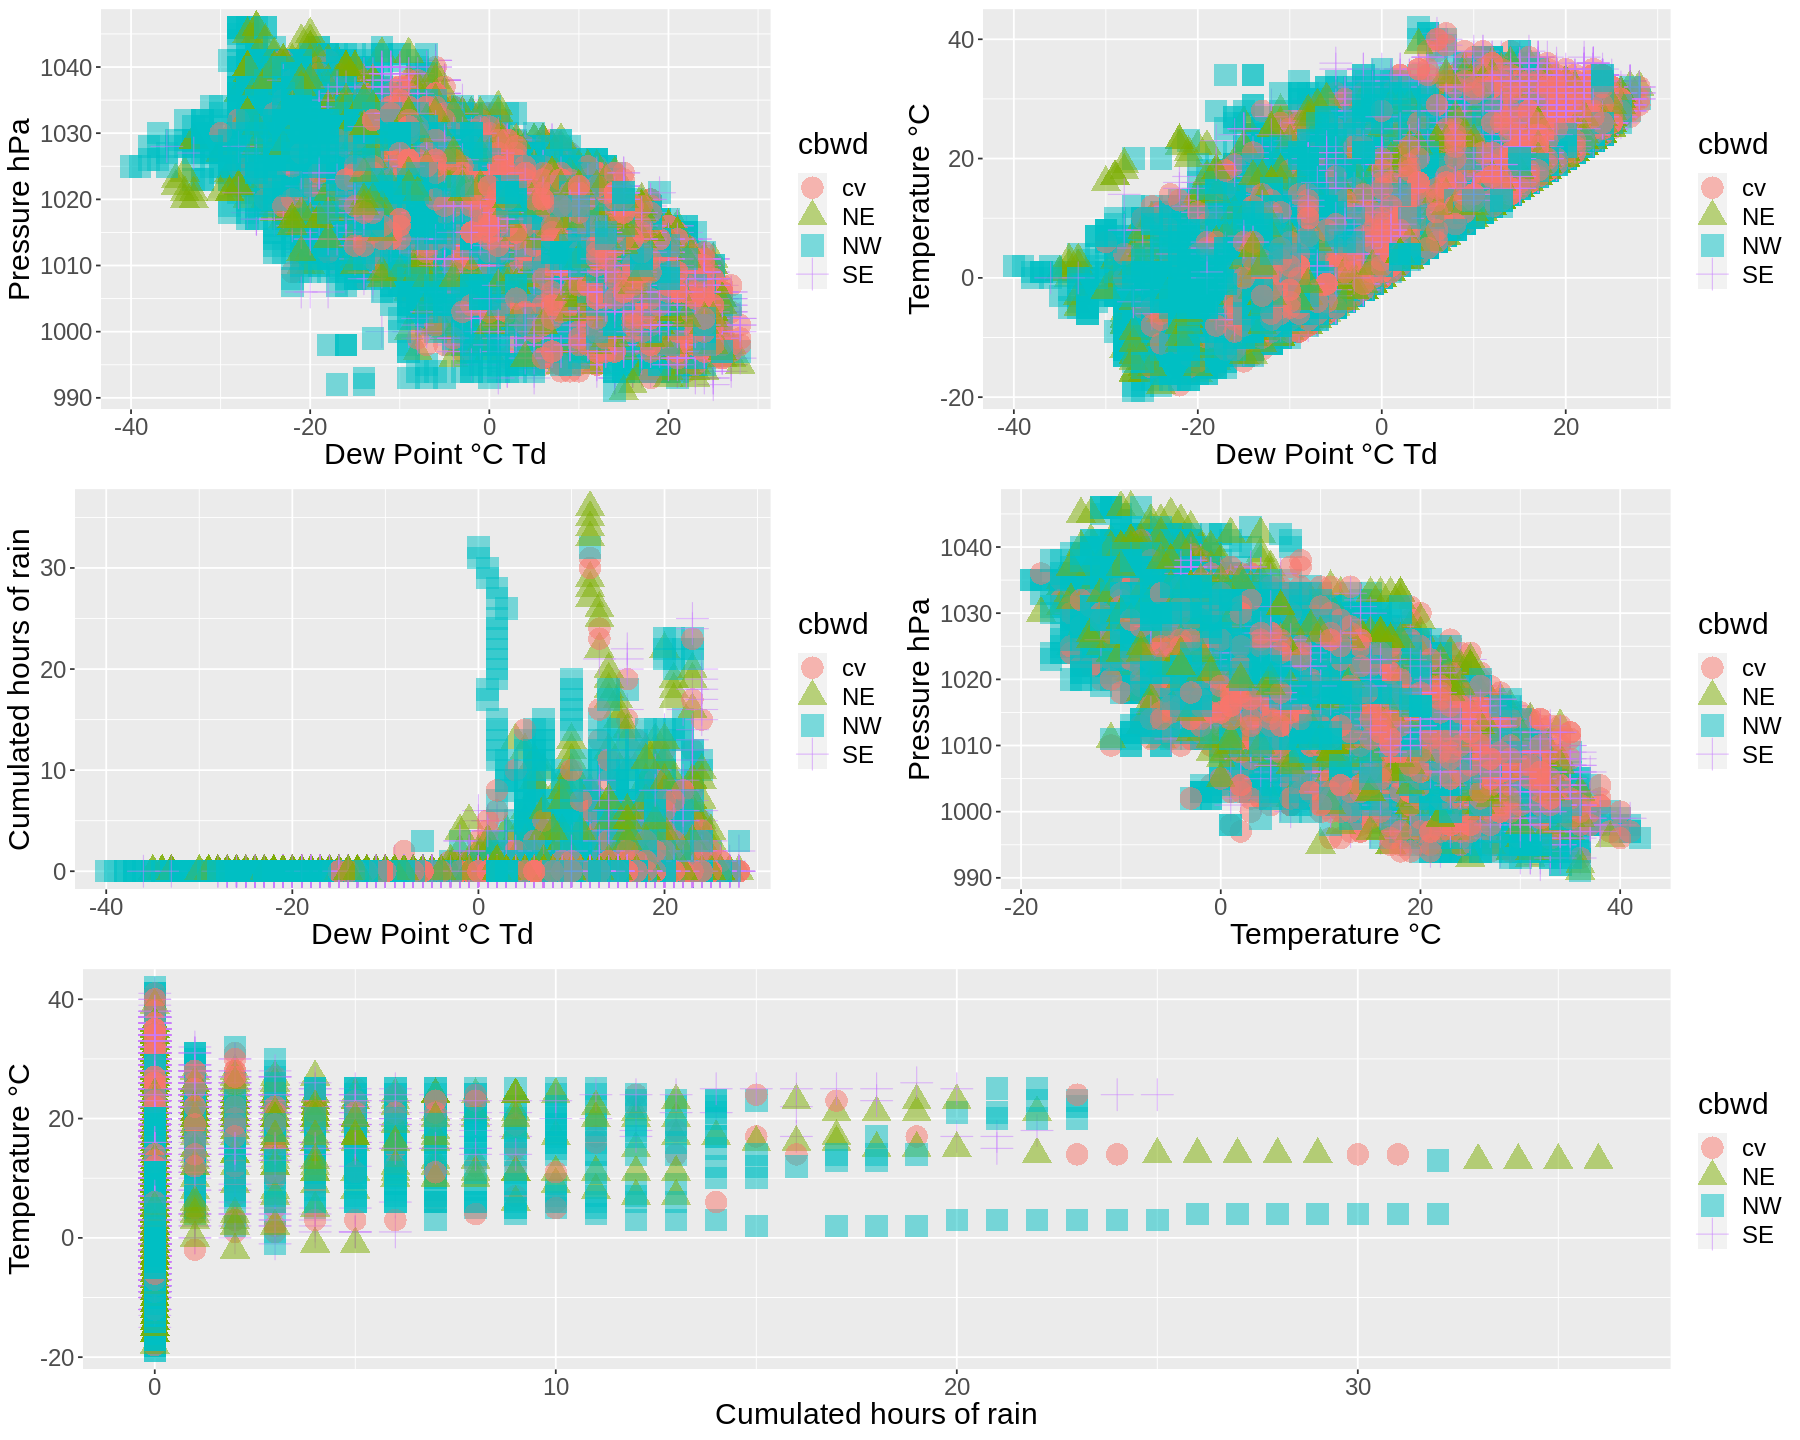

In [21]:
# variables correlated
options(repr.plot.width = 15, repr.plot.height = 12)
# dew point vs pressure 
dewp <- ggplot(pm2.5_s, aes(x = DEWP, y = PRES)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Dew Point °C Td") +
  ylab("Pressure hPa") +
  theme(text = element_text(size = 18))

# dew point vs temperature
temp <- ggplot(pm2.5_s, aes(x =DEWP , y = TEMP)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Dew Point °C Td") +
  ylab("Temperature °C") +
  theme(text = element_text(size = 18))

# dew point vs Ir
pres <- ggplot(pm2.5_s, aes(x = DEWP , y = Ir)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Dew Point °C Td") +
  ylab("Cumulated hours of rain") +
  theme(text = element_text(size = 18))



# temperature vs pressure 
snow <- ggplot(pm2.5_s, aes(x =TEMP , y = PRES)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Temperature °C") +
  ylab("Pressure hPa") +
  theme(text = element_text(size = 18))

# temperature vs rain
rain <- ggplot(pm2.5_s, aes(x =Ir , y = TEMP)) +
  geom_point(
    aes(color = cbwd, shape = cbwd),
    size = 6,
    alpha = 0.5
  )+
  xlab("Cumulated hours of rain") +
  ylab("Temperature °C") +
  theme(text = element_text(size = 18))

grid.newpage()
pushViewport(viewport(layout = grid.layout(3,2))) 
vplayout <- function(x, y) viewport(layout.pos.row = x, layout.pos.col = y)
print(dewp, vp = vplayout(1,1))   
print(temp, vp = vplayout(1,2))
print(pres, vp = vplayout(2,1))
print(snow, vp = vplayout(2,2))
print(rain, vp = vplayout(3,1:2))

In [22]:
model<-lm(pm2.5~DEWP+cbwd+Iws, data=pm2.5_s)
summary(model)


Call:
lm(formula = pm2.5 ~ DEWP + cbwd + Iws, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-132.31  -58.03  -25.59   32.58  918.69 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 125.172825   0.973203  128.62   <2e-16 ***
DEWP          0.511228   0.033948   15.06   <2e-16 ***
cbwdNE      -31.400763   1.641782  -19.13   <2e-16 ***
cbwdNW      -35.990439   1.340668  -26.84   <2e-16 ***
cbwdSE      -12.024687   1.243520   -9.67   <2e-16 ***
Iws          -0.325018   0.009858  -32.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 86.7 on 37698 degrees of freedom
Multiple R-squared:  0.09709,	Adjusted R-squared:  0.09697 
F-statistic: 810.7 on 5 and 37698 DF,  p-value: < 2.2e-16


In [19]:
# model selection 
library(leaps)
best<-regsubsets(pm2.5~DEWP+TEMP+PRES+Is+Ir+season+cbwd, data=pm2.5_s, method = c("exhaustive")) 
summary(best)$which

#1. adding the additional variables
#2. season levels 2
#3. wind direction?


,(Intercept),DEWP,TEMP,PRES,Is,Ir,seasonSpring,seasonSummer,seasonWinter,cbwdNE,cbwdNW,cbwdSE
1,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
2,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
3,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
4,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE
5,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE
6,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE
7,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE
8,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE


In [8]:
#fit model
one_v <- lm(pm2.5~DEWP,data= pm2.5_s)
one<- summary(one_v)
one


Call:
lm(formula = pm2.5 ~ DEWP, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-116.76  -60.67  -28.55   34.47  924.65 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 96.92934    0.46462  208.62   <2e-16 ***
DEWP         1.14902    0.03196   35.95   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 89.71 on 37702 degrees of freedom
Multiple R-squared:  0.03314,	Adjusted R-squared:  0.03311 
F-statistic:  1292 on 1 and 37702 DF,  p-value: < 2.2e-16


In [9]:
two_v<-lm(pm2.5~DEWP+TEMP, data=pm2.5_s)
two <- summary(two_v)
two


Call:
lm(formula = pm2.5 ~ DEWP + TEMP, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-149.41  -55.20  -17.30   34.73  890.99 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 156.32747    0.79652  196.26   <2e-16 ***
DEWP          4.90087    0.05162   94.95   <2e-16 ***
TEMP         -5.35867    0.06088  -88.02   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 81.71 on 37701 degrees of freedom
Multiple R-squared:  0.198,	Adjusted R-squared:  0.1979 
F-statistic:  4653 on 2 and 37701 DF,  p-value: < 2.2e-16


In [10]:
three_v<-lm(pm2.5~DEWP+TEMP+season, data=pm2.5_s)
three <- summary(three_v)
three


Call:
lm(formula = pm2.5 ~ DEWP + TEMP + season, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-159.52  -53.14  -15.63   33.43  905.27 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  131.45128    1.12817  116.52   <2e-16 ***
DEWP           6.27847    0.05731  109.55   <2e-16 ***
TEMP          -4.10225    0.06882  -59.61   <2e-16 ***
seasonSpring  19.03207    1.19755   15.89   <2e-16 ***
seasonSummer -51.71277    1.45667  -35.50   <2e-16 ***
seasonWinter  58.73764    1.55956   37.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 79.03 on 37698 degrees of freedom
Multiple R-squared:  0.2497,	Adjusted R-squared:  0.2496 
F-statistic:  2510 on 5 and 37698 DF,  p-value: < 2.2e-16


In [11]:
four_v<-lm(pm2.5~DEWP+TEMP+PRES+season, data=pm2.5_s)
four <- summary(four_v)
four


Call:
lm(formula = pm2.5 ~ DEWP + TEMP + PRES + season, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-171.25  -51.53  -15.12   33.21  903.27 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2073.19584   80.92197  25.620  < 2e-16 ***
DEWP            5.81739    0.06004  96.893  < 2e-16 ***
TEMP           -4.85499    0.07516 -64.595  < 2e-16 ***
PRES           -1.89415    0.07893 -23.998  < 2e-16 ***
seasonSpring    8.41581    1.26819   6.636 3.26e-11 ***
seasonSummer  -61.68800    1.50426 -41.009  < 2e-16 ***
seasonWinter   53.65664    1.56222  34.346  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 78.43 on 37697 degrees of freedom
Multiple R-squared:  0.261,	Adjusted R-squared:  0.2609 
F-statistic:  2219 on 6 and 37697 DF,  p-value: < 2.2e-16


In [12]:
five_v<-lm(pm2.5~DEWP+TEMP+PRES+season+Ir, data=pm2.5_s)
five <- summary(five_v)
five


Call:
lm(formula = pm2.5 ~ DEWP + TEMP + PRES + season + Ir, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-168.65  -51.27  -14.94   33.04  903.37 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2154.74727   80.26988  26.844  < 2e-16 ***
DEWP            5.98351    0.05985  99.971  < 2e-16 ***
TEMP           -5.05187    0.07488 -67.464  < 2e-16 ***
PRES           -1.97029    0.07829 -25.167  < 2e-16 ***
seasonSpring    8.08363    1.25707   6.431 1.29e-10 ***
seasonSummer  -62.25971    1.49116 -41.753  < 2e-16 ***
seasonWinter   52.19884    1.54946  33.688  < 2e-16 ***
Ir             -7.47142    0.28764 -25.974  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 77.74 on 37696 degrees of freedom
Multiple R-squared:  0.274,	Adjusted R-squared:  0.2739 
F-statistic:  2033 on 7 and 37696 DF,  p-value: < 2.2e-16


In [13]:
#
six_v<-lm(pm2.5~DEWP+TEMP+PRES+season+Ir+Is, data=pm2.5_s)
six <- summary(six_v)
six


Call:
lm(formula = pm2.5 ~ DEWP + TEMP + PRES + season + Ir + Is, data = pm2.5_s)

Residuals:
    Min      1Q  Median      3Q     Max 
-169.82  -51.27  -14.88   33.15  902.51 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2136.22340   80.20436  26.635  < 2e-16 ***
DEWP            6.03857    0.06008 100.510  < 2e-16 ***
TEMP           -5.09602    0.07495 -67.993  < 2e-16 ***
PRES           -1.95177    0.07823 -24.950  < 2e-16 ***
seasonSpring    8.65435    1.25716   6.884 5.91e-12 ***
seasonSummer  -62.22961    1.48948 -41.779  < 2e-16 ***
seasonWinter   53.26346    1.55197  34.320  < 2e-16 ***
Ir             -7.50814    0.28735 -26.129  < 2e-16 ***
Is             -4.62803    0.49895  -9.275  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 77.65 on 37695 degrees of freedom
Multiple R-squared:  0.2757,	Adjusted R-squared:  0.2755 
F-statistic:  1793 on 8 and 37695 DF,  p-value: < 2.2e-16


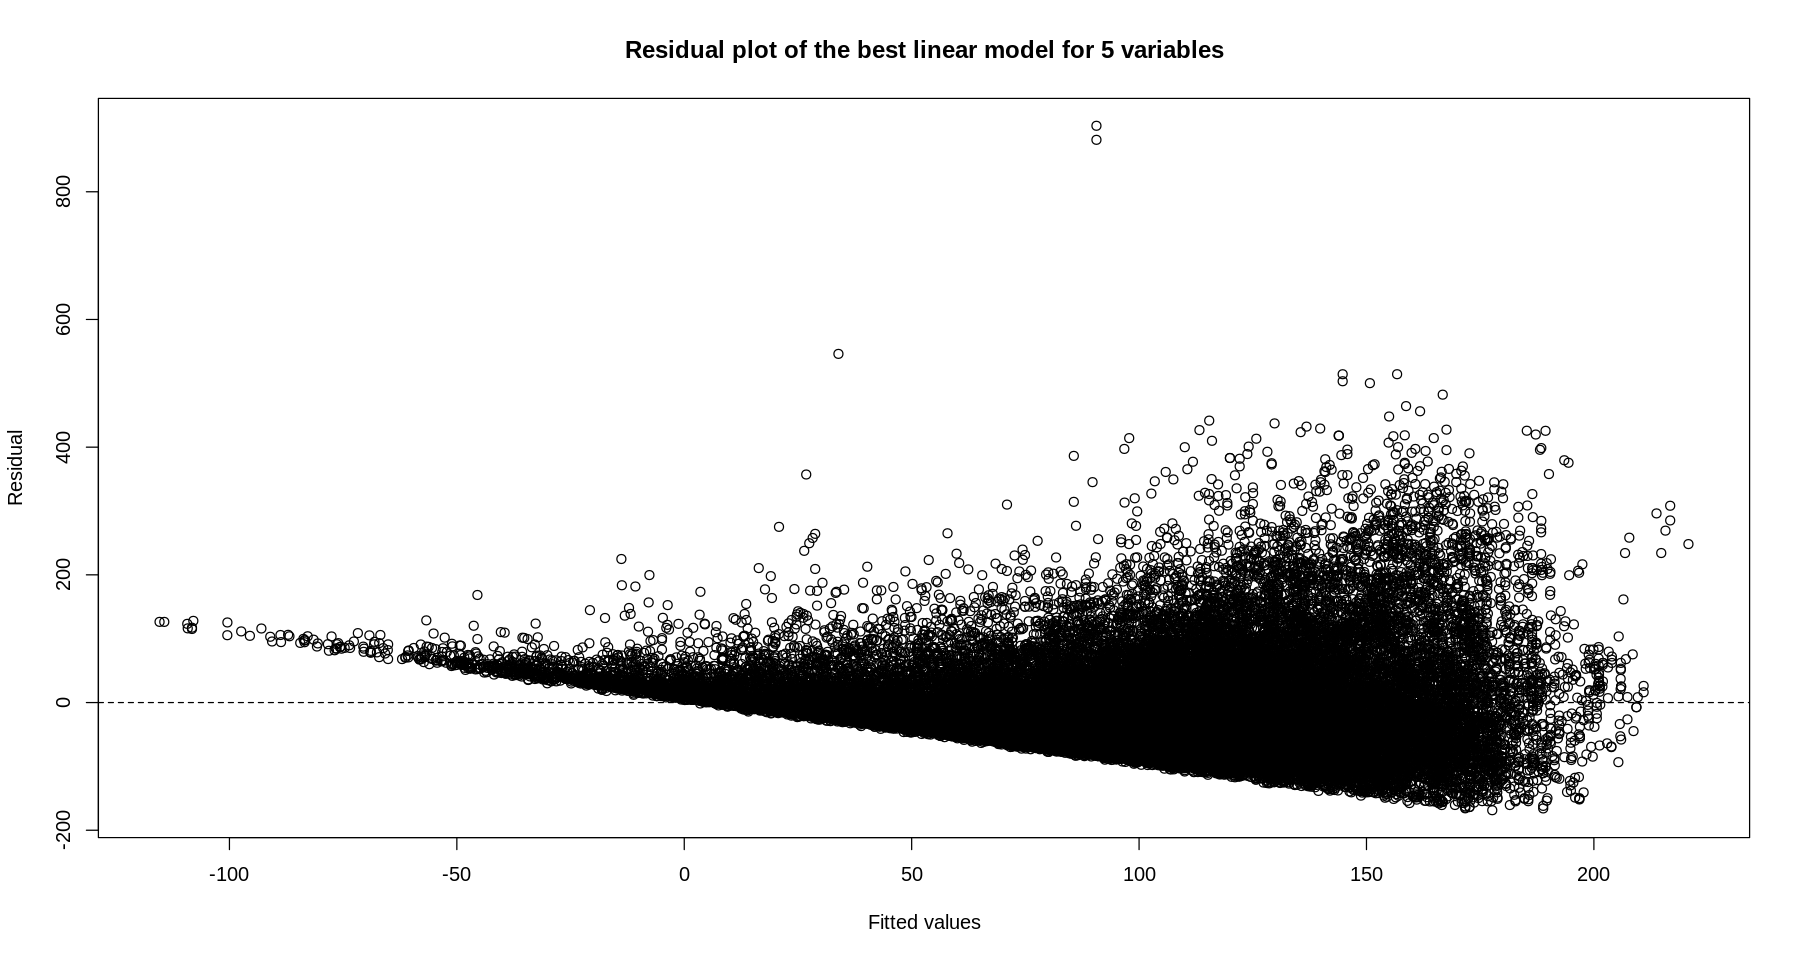

In [17]:
#residual plot v5
options(repr.plot.width = 15, repr.plot.height = 8)
plot(x = fitted(five_v), 
     y = residuals(five_v),
     xlab = "Fitted values",
     ylab = "Residual",
     main = "Residual plot of the best linear model for 5 variables")
abline(h = 0, lty = 2)

In [14]:
# get sample size n of our data
n<- nrow(pm2.5_s)
# sample a subset of half of our data
train <- sample.int(n,n/2)
traing_data<- pm2.5_s[train,]
testing_data<- pm2.5_s[-train,]

# summary of training data
summary(traing_data)

       No             year          month             day       
 Min.   :   27   Min.   :2010   Min.   : 1.000   Min.   : 1.00  
 1st Qu.:10539   1st Qu.:2011   1st Qu.: 3.000   1st Qu.: 8.00  
 Median :22190   Median :2012   Median : 7.000   Median :15.00  
 Mean   :22115   Mean   :2012   Mean   : 6.497   Mean   :15.57  
 3rd Qu.:33346   3rd Qu.:2013   3rd Qu.:10.000   3rd Qu.:23.00  
 Max.   :43824   Max.   :2014   Max.   :12.000   Max.   :31.00  
      hour           pm2.5             DEWP              TEMP       
 Min.   : 0.00   Min.   :  0.00   Min.   :-39.000   Min.   :-18.00  
 1st Qu.: 6.00   1st Qu.: 29.00   1st Qu.:-11.000   1st Qu.:  1.00  
 Median :12.00   Median : 73.00   Median :  1.000   Median : 13.00  
 Mean   :11.53   Mean   : 99.41   Mean   :  1.542   Mean   : 12.17  
 3rd Qu.:18.00   3rd Qu.:139.00   3rd Qu.: 15.000   3rd Qu.: 23.00  
 Max.   :23.00   Max.   :671.00   Max.   : 28.000   Max.   : 42.00  
      PRES          cbwd                Iws               Is  

In [15]:
# prediction error for model with 6 variables
reg6_1<-lm(pm2.5 ~ DEWP + TEMP + PRES + season + Ir + Is, data=pm2.5_s[train,])
error1<-sum((pm2.5_s$pm2.5[-train]-predict(reg6_1,pm2.5_s[-train,]))^2)
reg6_2<-lm(pm2.5 ~ DEWP + TEMP + PRES + season + Ir + Is, data=pm2.5_s[-train,])
error2<-sum((pm2.5_s$pm2.5[train]-predict(reg6_2,pm2.5_s[train,]))^2)
error_6v<-(error1+error2)/dim(pm2.5_s)[1]
error_6v

# prediction error for model with 5 variables
reg1<-lm(pm2.5 ~ DEWP + TEMP + PRES + season + Ir, data=pm2.5_s[train,])
error1<-sum((pm2.5_s$pm2.5[-train]-predict(reg1,pm2.5_s[-train,]))^2)
reg2<-lm(pm2.5 ~ DEWP + TEMP + PRES + season + Ir, data=pm2.5_s[-train,])
error2<-sum((pm2.5_s$pm2.5[train]-predict(reg2,pm2.5_s[train,]))^2)
error5_v<-(error1+error2)/dim(pm2.5_s)[1]
error5_v

[1] 6032.838

[1] 6046.253